## Deep Convolutional Generative Adversarial Network (DCGAN*) implemented in PyTorch.
[![forthebadge made-with-python](http://ForTheBadge.com/images/badges/made-with-python.svg)](https://www.python.org/)
[![ForTheBadge built-with-love](http://ForTheBadge.com/images/badges/built-with-love.svg)](https://GitHub.com/Naereen/)

#### Import Libraries and packages :

In [9]:
# system
import os
import argparse
# torch
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
import torchvision.utils as vutils
from torchvision import transforms, datasets
# visualization 
from IPython import display

import numpy as np
import  matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
# tensorboard
from torch.utils.tensorboard import SummaryWriter

#### Define useful functions : 

In [10]:
def get_dataset(batch_size, path):

    TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
    ])

    train_data = torchvision.datasets.ImageFolder(root=path, transform=TRANSFORM_IMG)
    data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True,num_workers=2)
    num_batches = np.ceil(len(train_data)/batch_size)
    return data_loader,num_batches

def real_data_target(size):
    '''
    Tensor containing ones, with shape = (size,3)
    '''
    data = Variable(torch.ones(size, 3))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = (size,3)
    '''
    data = Variable(torch.zeros(size, 3))
    if torch.cuda.is_available(): return data.cuda()
    return data

# weights initialisation
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

# create latent space vector
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available():
        return n.cuda()
    return n

##### Define Generator , discriminator Model ( Class ) : 

#### Disciminator : 

In [11]:
class DiscriminativeNet(torch.nn.Module):
    def __init__(self):
        super(DiscriminativeNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 3),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

#### Generator :

In [12]:
class GenerativeNet(torch.nn.Module):

    def __init__(self):
        super(GenerativeNet, self).__init__()

        self.linear = nn.Linear(100, 1024*4*4)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False
            )
        )
        self.conv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # Apply Tanh
        return self.out(x)

#### Define Functions to train Generator/Discriminator :  

#### Discriminator :

In [13]:
def train_discriminator(discriminator,optimizer, real_data, fake_data,loss):
    # Reset gradients
    optimizer.zero_grad()
    
    # Train on Real Data
    prediction_real = discriminator(real_data)
    
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Train on Fake Data
    prediction_fake = discriminator(fake_data)
    
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

#### Generator :

In [14]:
def train_generator(discriminator, optimizer, fake_data,loss):
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

#### Define useful variables

In [15]:
batch_size , path , learning_rate , epochs = 128, '.\RPEDATA', 0.0002, 50

#### Writer Summary for tensorboard :  

In [16]:
sw = SummaryWriter('./runs')

#### Images Display function :

In [17]:
def Normlize_samples(images):
    res = (images-images.min())/(images.max()-images.min())
    return res
def plot_samples(images,label):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(label)
    plt.imshow(np.transpose(images.cpu()))
    plt.show()

#### Define the model, loss, optim :

In [18]:
# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

#Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
        
# Optimizers
d_optimizer = Adam(discriminator.parameters(), lr=learning_rate , betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

##### Get Data : ( change path to other data folder)

In [19]:
train_data ,num_batches = get_dataset(batch_size,path)
os.makedirs(os.path.join("Generated_Images_numpy_notebook"), exist_ok=True)

#### Save images grid to tensorboard :

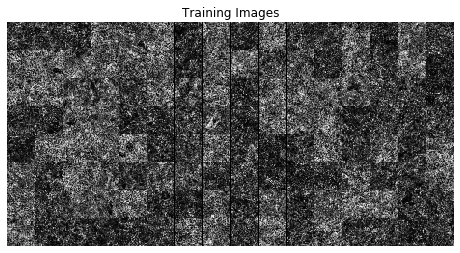

In [20]:
images, _ = next(iter(train_data))
grid = torchvision.utils.make_grid(Normlize_samples(images))
plot_samples(grid,'Training Images')
sw.add_image('Training Images', grid)
sw.close()

#### Number of test examples ( visualization of test examples for training in tensorboard ) :

In [21]:
num_test_samples = 4
test_noise = noise(num_test_samples)

#### Training loop :

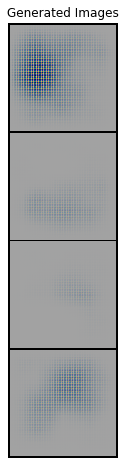

In [ ]:
for epoch in range(epochs):
    total_d_error, total_g_error = 0, 0
    for n_batch, (real_batch,_) in enumerate(train_data):
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available():
            real_data = real_data.cuda()

        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator,d_optimizer, real_data, fake_data,loss)
        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(discriminator, g_optimizer, fake_data, loss)

        total_d_error+= d_error
        total_g_error+= g_error

        # Display Progress
        if (n_batch) % 10 == 0:
            display.clear_output(True)
            test_images = generator(test_noise).data
            grid = torchvision.utils.make_grid(Normlize_samples(test_images))
            plot_samples(grid[:],'Generated Images')
            sw.add_image('Generated Images', grid, epoch+1)
            sw.close()
    sw.add_scalar('Generator loss', total_g_error, epoch+1)
    sw.add_scalar('Discriminator loss', total_d_error, epoch+1)
    sw.add_scalar('G(x)', d_pred_real.mean(), epoch+1)
    sw.add_scalar('D(g(z))', d_pred_fake.mean(), epoch+1)
    print('Epoch: [{}/{}]'.format(epoch, epochs))
    print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))
    print('Loss Generator : {:.4f}, Loss Discriminator :  {:.4f}'.format(total_g_error.mean(), total_d_error.mean()))
    if epoch % 25 :
        sample = np.random.choice(4)
        #Save numpy array of test_images every 25 epochs :
        np.save('Generated_Images_numpy_notebook/generated_image{}'.format(epoch), test_images[sample].cpu().numpy())

#### Save the Model after training : 

In [28]:
print("Done training ( the model is saved as Generator_128.pth )")
torch.save(generator.state_dict(), './generator_128.pth')

Done training ( the model is saved as Generator_128.pth )


Testing the Model ( Generating 128 x 128 synthetic images ) :


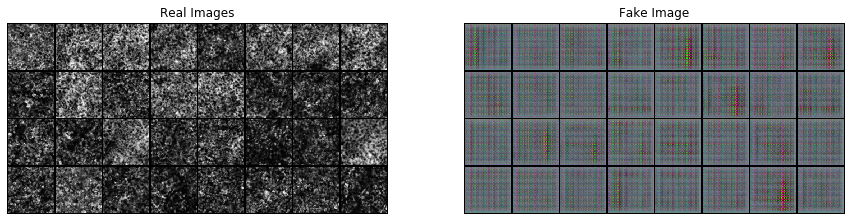

Done Testing


In [34]:
print("Testing the Model ( Generating 128 x 128 synthetic images ) :")

num_test_samples = 32
test_noise = noise(num_test_samples)
test_images = generator(test_noise).data.cpu()

# Grab a batch of real images from the dataloader²
real_batch = next(iter(train_data))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:num_test_samples], padding=4, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Image")
plt.imshow(np.transpose(vutils.make_grid(Normlize_samples(test_images[:]), padding=4, normalize=True).cpu(), (1, 2, 0)))
plt.show()
plt.close()

print("Done Testing")

## Display results ( over epoch , batch ) seperately (from saved numpy arrays) : 

In [ ]:
img = np.load('./Generated_Images_numpy_notebook/generated_image3.npy')
img -= img.min()
img /=(img.max()-img.min())
plt.imshow(np.transpose(img,(2,1,0)))